# From NumPy to PyTorch

In the previous notebook, we implemented a 2-2-1 neural network from scratch using NumPy. We had to:

1. Manually implement the forward pass
2. Manually calculate gradients for backpropagation
3. Manually implement the weight updates

In this notebook, we'll see how PyTorch makes this much simpler by:

1. Automatically computing gradients (autograd)
2. Providing built-in layers and loss functions
3. Handling the optimization automatically

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

## Define the PyTorch Model

Notice how much simpler this is compared to the NumPy implementation:

* We don't need to manually implement forward pass matrix operations
* We don't need to manually compute gradients
* We don't need to manually update weights

PyTorch's `nn.Module` handles the architecture, and autograd handles the backpropagation!

In [2]:
class PyTorchNN(nn.Module):
    """
    2-2-1 Neural Network with Binary Cross-Entropy loss and Sigmoid activations.
    This is the PyTorch equivalent of NumpyNNwithBCE.
    """
    def __init__(self):
        super(PyTorchNN, self).__init__()
        
        # Define the layers
        # Layer 0 to Layer 1: 2 inputs -> 2 hidden neurons
        self.fc1 = nn.Linear(2, 2)
        
        # Layer 1 to Layer 2: 2 hidden neurons -> 1 output
        self.fc2 = nn.Linear(2, 1)
        
        # Activation function
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Forward pass through the network
        x = self.sigmoid(self.fc1(x))  # Input -> Hidden (with sigmoid)
        x = self.sigmoid(self.fc2(x))  # Hidden -> Output (with sigmoid)
        return x

## Training Function

The training loop in PyTorch follows a standard pattern:

1. **Forward pass**: Compute predictions
2. **Compute loss**: Calculate how wrong the predictions are
3. **Backward pass**: PyTorch's autograd computes all gradients automatically!
4. **Update weights**: The optimizer updates weights using the computed gradients

Compare this to our NumPy implementation where we had to manually:
- Calculate `dZ2 = A2 - target`
- Calculate `dA1 = dZ2.dot(W1.T)`
- Calculate `dZ1 = dA1 * sigmoid_derivative(A1)`
- Update all weights manually

PyTorch does all of this with just `loss.backward()`!

In [3]:
def train_model(model, X, y, epochs=1000, learning_rate=0.1, print_every=100):
    """
    Train the PyTorch model.
    
    Args:
        model: The neural network model
        X: Input data (numpy array or torch tensor)
        y: Target labels (numpy array or torch tensor)
        epochs: Number of training iterations
        learning_rate: Learning rate for optimization
        print_every: Print loss every N epochs
    """
    # Convert numpy arrays to PyTorch tensors if needed
    if isinstance(X, np.ndarray):
        X = torch.FloatTensor(X)
    if isinstance(y, np.ndarray):
        y = torch.FloatTensor(y)
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        # Zero the gradients from previous iteration
        optimizer.zero_grad()
        
        # Forward pass: compute predictions
        outputs = model(X)
        
        # Compute loss
        loss = criterion(outputs, y)
        
        # Backward pass: compute gradients automatically!
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Print progress
        if epoch == 0 or (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}: loss={loss.item():.7f}")
    
    return model

## Test with Simple XOR Dataset

Let's test with the same simple 4-sample XOR dataset we used in the NumPy notebook.

In [4]:
# Create the simple XOR dataset
X = np.array([[0, 0], 
              [0, 1], 
              [1, 0], 
              [1, 1]], dtype=np.float32)
y = np.array([[0], 
              [1], 
              [1], 
              [0]], dtype=np.float32)

# Initialize and train the model
model = PyTorchNN()
model = train_model(model, X, y, epochs=20_000, learning_rate=0.03, print_every=2000)

Epoch 1: loss=0.7043160
Epoch 2000: loss=0.6917434
Epoch 4000: loss=0.6890959
Epoch 6000: loss=0.6775653
Epoch 4000: loss=0.6890959
Epoch 6000: loss=0.6775653
Epoch 8000: loss=0.6262016
Epoch 10000: loss=0.4890359
Epoch 8000: loss=0.6262016
Epoch 10000: loss=0.4890359
Epoch 12000: loss=0.2522772
Epoch 14000: loss=0.1259805
Epoch 12000: loss=0.2522772
Epoch 14000: loss=0.1259805
Epoch 16000: loss=0.0775922
Epoch 18000: loss=0.0547130
Epoch 16000: loss=0.0775922
Epoch 18000: loss=0.0547130
Epoch 20000: loss=0.0418255
Epoch 20000: loss=0.0418255


In [5]:
# Make predictions
with torch.no_grad():  # No need to compute gradients during inference
    X_tensor = torch.FloatTensor(X)
    y_pred = model(X_tensor).numpy()
    y_pred_classes = (y_pred > 0.5).astype(int)

print("Predictions:")
print(y_pred)
print("\nClassification Report:")
print(classification_report(y, y_pred_classes))

Predictions:
[[0.04029806]
 [0.94413644]
 [0.9660447 ]
 [0.03354448]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



## Test with More Complex XOR Dataset

Now let's test with a more complex dataset with noise, just like in the NumPy notebook.

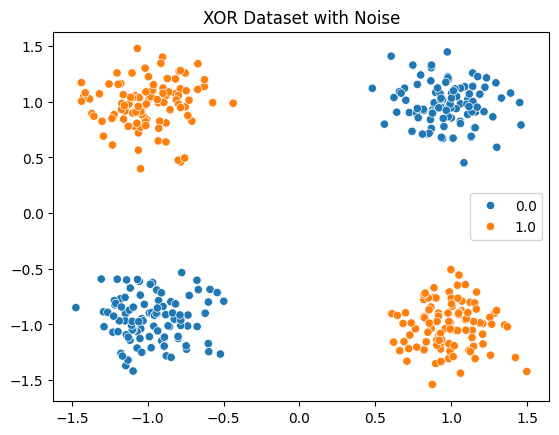

In [6]:
# Generate XOR data with noise (same as NumPy notebook)
np.random.seed(0)
n_points = 100
noise = 0.1

X_complex = np.vstack((
    np.random.normal(loc=[0.0, 0.0], scale=noise, size=(n_points, 2)),
    np.random.normal(loc=[1.0, 1.0], scale=noise, size=(n_points, 2)),
    np.random.normal(loc=[0.0, 1.0], scale=noise, size=(n_points, 2)),
    np.random.normal(loc=[1.0, 0.0], scale=noise, size=(n_points, 2))
)).astype(np.float32)

y_complex = np.array([0]*n_points + [0]*n_points + [1]*n_points + [1]*n_points).reshape(-1, 1).astype(np.float32)

# Apply Z-score normalization
X_complex = (X_complex - X_complex.mean(axis=0)) / X_complex.std(axis=0)

# Visualize the data
sns.scatterplot(x=X_complex[:,0], y=X_complex[:,1], hue=y_complex.flatten())
plt.title("XOR Dataset with Noise")
plt.show()

## Train and Visualize Decision Boundary

Epoch 1: loss=0.6951926
Epoch 1000: loss=0.6921903
Epoch 2000: loss=0.6878261
Epoch 3000: loss=0.6751117
Epoch 4000: loss=0.6415981
Epoch 5000: loss=0.5890861
Epoch 3000: loss=0.6751117
Epoch 4000: loss=0.6415981
Epoch 5000: loss=0.5890861
Epoch 6000: loss=0.5185733
Epoch 7000: loss=0.4091317
Epoch 8000: loss=0.3007326
Epoch 6000: loss=0.5185733
Epoch 7000: loss=0.4091317
Epoch 8000: loss=0.3007326
Epoch 9000: loss=0.2263147
Epoch 10000: loss=0.1776864
Epoch 11000: loss=0.1446520
Epoch 9000: loss=0.2263147
Epoch 10000: loss=0.1776864
Epoch 11000: loss=0.1446520
Epoch 12000: loss=0.1211624
Epoch 13000: loss=0.1037839
Epoch 14000: loss=0.0904960
Epoch 12000: loss=0.1211624
Epoch 13000: loss=0.1037839
Epoch 14000: loss=0.0904960
Epoch 15000: loss=0.0800552
Epoch 16000: loss=0.0716629
Epoch 17000: loss=0.0647869
Epoch 15000: loss=0.0800552
Epoch 16000: loss=0.0716629
Epoch 17000: loss=0.0647869
Epoch 18000: loss=0.0590612
Epoch 19000: loss=0.0542264
Epoch 20000: loss=0.0500944
Epoch 18000:

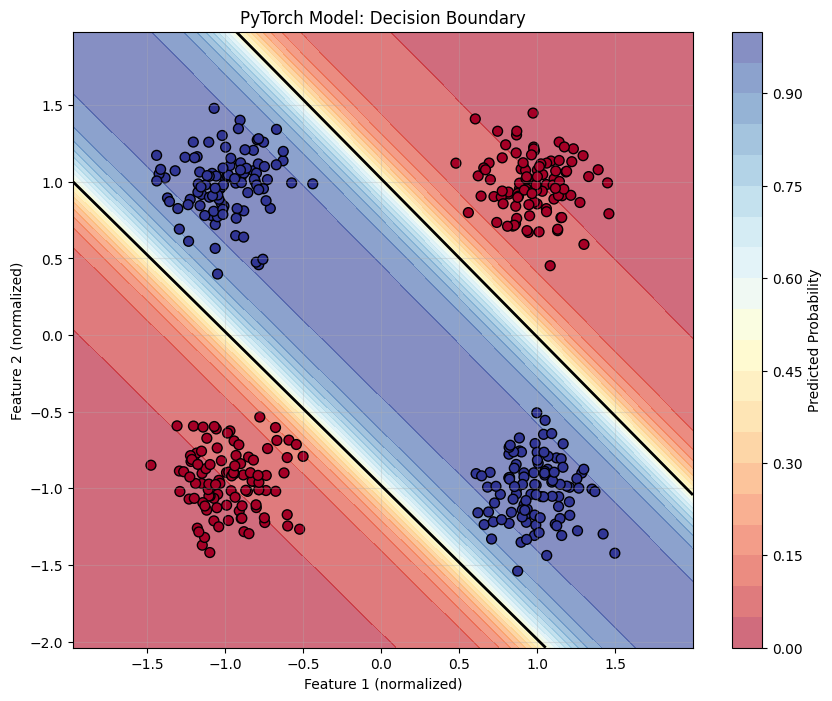

In [11]:
# Initialize and train a new model
model_complex = PyTorchNN()
model_complex = train_model(model_complex, X_complex, y_complex, 
                            epochs=20_000, learning_rate=0.03, print_every=1_000)

# Create a mesh grid for decision boundary visualization
x_min, x_max = X_complex[:, 0].min() - 0.5, X_complex[:, 0].max() + 0.5
y_min, y_max = X_complex[:, 1].min() - 0.5, X_complex[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on the mesh grid
with torch.no_grad():
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    Z = model_complex(grid_tensor).numpy()
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.6)
plt.colorbar(label='Predicted Probability')
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

# Plot the data points
scatter = plt.scatter(X_complex[:, 0], X_complex[:, 1], c=y_complex.flatten(), 
                     cmap='RdYlBu', edgecolors='black', s=50)
plt.xlabel('Feature 1 (normalized)')
plt.ylabel('Feature 2 (normalized)')
plt.title('PyTorch Model: Decision Boundary')
plt.grid(True, alpha=0.3)
plt.show()

## Key Takeaways

### What We Had to Implement in NumPy:
1. **Manual forward pass**: Matrix multiplications, activations
2. **Manual backward pass**: Computing all gradients
   - `dZ2 = A2 - target`
   - `dA1 = dZ2.dot(W1.T)`
   - `dZ1 = dA1 * sigmoid_derivative(A1)`
3. **Manual weight updates**: Gradient descent
   - `W1 -= learning_rate * A1.T.dot(dZ2)`
   - `W0 -= learning_rate * A0.T.dot(dZ1)`
   - Plus biases

### What PyTorch Provides:
1. **Automatic forward pass**: Just define layers in `__init__` and call them in `forward()`
2. **Automatic backward pass**: Just call `loss.backward()` - PyTorch computes ALL gradients!
3. **Automatic optimization**: Optimizer handles weight updates

### The Magic of Autograd:
- PyTorch tracks all operations on tensors
- Builds a computational graph automatically
- Computes gradients via reverse-mode automatic differentiation
- **No manual gradient calculations needed!**

This is why PyTorch (and other deep learning frameworks) are so powerful - they handle the hard part (backpropagation) correctly and efficiently, letting you focus on architecture and experimentation.